In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import glob
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *

In [3]:
def down_block(x, filters, use_maxpool = True):
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_maxpool == True:
        return  MaxPooling2D(strides= (2,2))(x), x
    else:
        return x

In [4]:
def up_block(x,y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

In [5]:
def Unet(input_size = (256, 256, 3)):
    filter = [8,16,32,128,256]
    # encode
    input = Input(shape = input_size)
    x, temp1 = down_block(input, filter[0])
    x = MaxPooling2D()(x)
    x, temp2 = down_block(x, filter[1])
    x = MaxPooling2D()(x)
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool= False)

    # decode
    x = up_block(x, temp4, filter[3])
    # x = Conv2DTranspose(filter[3], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[3], 3, padding='same')(x)
    x = up_block(x, temp3, filter[2])
    # x = Conv2DTranspose(filter[2], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[2], 3, padding='same')(x)
    x = UpSampling2D()(x)
    x = up_block(x, temp2, filter[1])
    # x = Conv2DTranspose(filter[1], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[1], 3, padding='same')(x)
    x = UpSampling2D()(x)
    x = up_block(x, temp1, filter[0])
    # x = Conv2DTranspose(filter[0], 3, padding='same')(x)
    # x = Conv2DTranspose(filter[0], 3, padding='same')(x)
    output = Conv2DTranspose(3, 3, padding = 'same', activation = 'sigmoid')(x)

    model = models.Model(input, output, name = 'unet')
    model.summary()
    return model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dir = '/content/drive/MyDrive/DL_project/dataset'

In [8]:
classes=['freshapples',
         'freshbanana',
        #  'freshoranges',
         ]

In [9]:
train_data = []
shape = (256,256)

for i in range(len(classes)):
  path = dir + '/train/' + classes[i] + '/*.png'
  for filename in glob.glob(path):
    img = cv2.imread(filename)
    img = cv2.resize(img, shape)
    train_data.append(img)
train_data = np.array(train_data)
print(train_data.shape)

(1693, 256, 256, 3)


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_val = train_test_split(train_data, test_size = 0.33, random_state = 42, shuffle = True)
print(x_train.shape)
print(x_val.shape)

(1134, 256, 256, 3)
(559, 256, 256, 3)


In [12]:
# x_train = np.array([np.array(val) for val in train_data])
# x_val = np.array([np.array(val) for val in train_data[955-95:]])

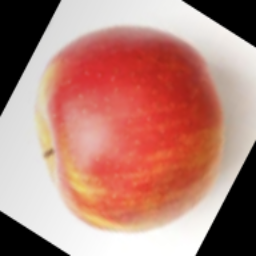

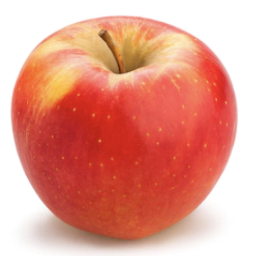

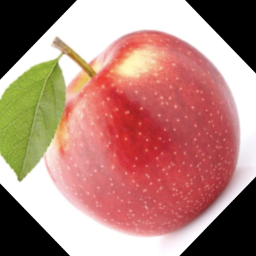

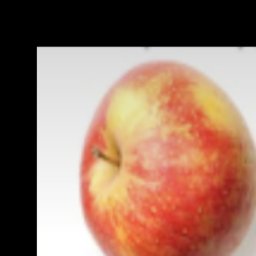

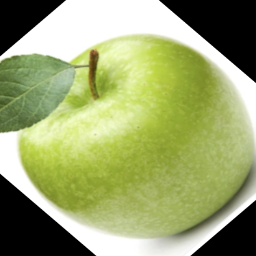

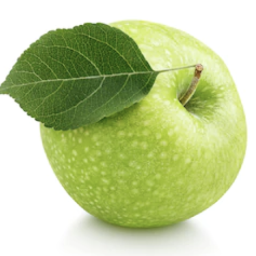

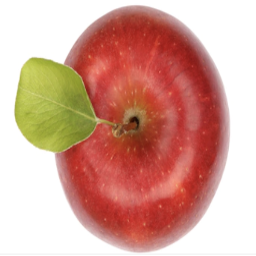

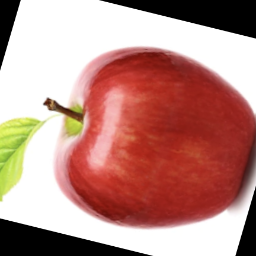

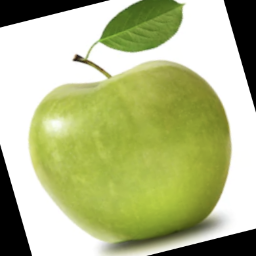

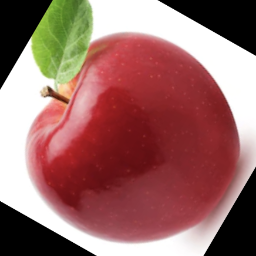

In [13]:
for i in range(10):
  cv2_imshow(x_train[i])

In [14]:
def scheduler(epoch, lr):
  if epoch < 90:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
checkpoint_path =  '/content/drive/MyDrive/DL_project/unet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

In [16]:
x_train = x_train/255
x_val = x_val/255

In [17]:
model = Unet()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 8)          32        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)          0         ['batch_normalization[0][0]

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    loss='mse'
)

In [ ]:
history = model.fit(x_train, x_train,
          epochs = 30,
          batch_size = 12,
          validation_data = (x_val, x_val),
          callbacks = [lr_schedule, cp_callback])

Epoch 1/150
38/38 [==============================] - ETA: 0s - loss: 0.0381
Epoch 1: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
38/38 [==============================] - 50s 641ms/step - loss: 0.0381 - val_loss: 0.0808 - lr: 0.0010
Epoch 2/150
38/38 [==============================] - ETA: 0s - loss: 0.0077
Epoch 2: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
38/38 [==============================] - 16s 436ms/step - loss: 0.0077 - val_loss: 0.0484 - lr: 0.0010
Epoch 3/150
38/38 [==============================] - ETA: 0s - loss: 0.0036
Epoch 3: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
38/38 [==============================] - 15s 387ms/step - loss: 0.0036 - val_loss: 0.0338 - lr: 0.0010
Epoch 4/150
38/38 [==============================] - ETA: 0s - loss: 0.0027
Epoch 4: saving model to /content/drive/MyDrive/DL_project/unet/cp.ckpt
38/38 [==============================] - 14s 384ms/step - loss: 0.0027 - val_loss: 0.0234 - lr: 0.0

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)